## Previsão do preço de imóveis 

### O projeto busca identificar o valor de um imóvel a partir de suas características.

### Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

### Importando dados

In [2]:
dados = pd.read_csv("ImovelDados\conjunto_de_treinamento.csv")
dados_teste = pd.read_csv("ImovelDados\conjunto_de_teste.csv")
exemplo = pd.read_csv("ImovelDados\exemplo_arquivo_respostas.csv")


### Limpando os dados


#### Primeiramente foram retiradas as colunas indesejadas


In [3]:
dados.set_index('Id', inplace=True)
dados_teste.set_index('Id', inplace=True)

dados = dados.drop(['bairro', # One Hot encoding muito grande
                    'diferenciais'],axis=1) # Informação já binarizada em outras colunas


dados_teste = dados_teste.drop(['bairro', # One Hot encoding muito grande
                                'diferenciais'],axis=1) # Informação já binarizada em outras colunas


#### Depois foi feita uma análise para avaliar médias de preço de cada coluna e se alguma coluna possuía valores nulos

In [4]:
for coluna in dados.columns:
    print(coluna)
    print(dados[coluna].value_counts())
    print(dados.groupby(coluna).preco.mean())
    
for coluna in dados.columns:
    print(pd.isnull(dados[coluna]).sum())

tipo
Apartamento    4501
Casa            177
Loft              3
Quitinete         2
Name: tipo, dtype: int64
tipo
Apartamento    9.096723e+05
Casa           1.404853e+06
Loft           3.383333e+05
Quitinete      1.675000e+05
Name: preco, dtype: float64
tipo_vendedor
Imobiliaria      4556
Pessoa Fisica     127
Name: tipo_vendedor, dtype: int64
tipo_vendedor
Imobiliaria      7.101393e+05
Pessoa Fisica    8.732672e+06
Name: preco, dtype: float64
quartos
3    2278
4    1226
2     892
1     189
5      65
6      21
7       7
8       3
9       2
Name: quartos, dtype: int64
quartos
1    6.547731e+05
2    7.286897e+05
3    8.067960e+05
4    1.275856e+06
5    1.763251e+06
6    1.650905e+06
7    1.655714e+06
8    1.933333e+06
9    9.750000e+05
Name: preco, dtype: float64
suites
1    2725
2     668
0     563
4     427
3     278
5      18
6       4
Name: suites, dtype: int64
suites
0    4.899762e+05
1    6.050862e+05
2    1.919670e+06
3    1.150980e+06
4    1.765574e+06
5    3.001406e+06
6    2.3

#### Sabendo que alguns algoritmos necessitam que todos os dados sejam numéricos e não categóricos, foi utilizada a técnina de "One-Hot Encoding" para fazer esta conversão

In [5]:
dados = pd.get_dummies(dados,columns=['tipo','tipo_vendedor'])

dados_teste = pd.get_dummies(dados_teste,columns=['tipo',
                                      'tipo_vendedor'])

dados_teste['tipo_Quitinete'] = 0 # Adicionando coluna para deixar as tabelas de dados e dados_teste iguais



#### Colunas com diferenças nas médias menores que 2 foram então retiradas da tabela

In [6]:
atributos_selecionados = ['quartos', 
                          'suites', 
                          'vagas', 
                          'area_util', 
                          'area_extra',
                           'churrasqueira', 
                           'estacionamento', 
                           'piscina', 
                           'playground', 
                           'quadra',
                           's_festas', 
                           's_jogos', 
                           's_ginastica', 
                           'sauna', 
                           'vista_mar',
                           'tipo_Apartamento', 
                           'tipo_Casa', 
                           'tipo_Loft', 
                           'tipo_Quitinete',
                           'tipo_vendedor_Imobiliaria', 
                           'tipo_vendedor_Pessoa Fisica',
                           'preco']

dados = dados[atributos_selecionados]
dados_teste = dados_teste[atributos_selecionados[0:-1]]

### Dividindo o dataset

#### Separamos então a coluna alvo dos atributos, e em seguida os conjuntos de treinameno e de teste

In [7]:
X = dados.iloc[:,dados.columns != 'preco'].values
y = dados.iloc[:,dados.columns == 'preco'].values.ravel()


X_train, X_test, y_train,y_test = train_test_split(X,y, train_size=3300, random_state = 42)

### Ajustando a escala

#### Para evitar que atributos tenham pesos maiores que outros, precisamos ajustar a escala dos conjuntos de dados

In [8]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
dados_teste = scaler.transform(dados_teste)

### Avaliando resultados dos modelos

#### Foi criada uma função para auxilar na visualização dos melhores parâmetros de um modelo escolhido, que neste caso foram o KNN, RandomForestRegressor e GradientBoostRegressor

In [9]:
def resultados(grid):
    results = pd.DataFrame(grid.cv_results_)
    results.sort_values(by='rank_test_score', inplace=True)
    results = results[['params','mean_test_score','std_test_score']].head()
    
    return results

#### E utilizando a função GridSearchCV encontramos os melhores modelos para cada algoritmo, utilizando como base de precisão seus respectivos RMSE

In [10]:
# RandomForest

parametersRF = {
    "max_depth":[2,4,10],
    "max_features": ['auto'],
    "n_estimators": [500],
    "min_samples_leaf":[2,5,8],
    "criterion":['mae'],
    }

gridRF = GridSearchCV(RandomForestRegressor(), parametersRF,  scoring='neg_mean_squared_error',cv=2, verbose=2, n_jobs =-1)
gridRF.fit(X, y)

resultadosRF = resultados(gridRF)
bestRF = gridRF.best_estimator_
bestRF.fit(X,y)
respostaRF = bestRF.predict(dados_teste)


# KNN

parametersKNN = {
    "p": [1,2],
    "n_neighbors": list(range(200,851,20)),
    'weights': ['uniform'],
    'algorithm':['auto']
    }

gridknn = GridSearchCV(KNeighborsRegressor(), parametersKNN, scoring='neg_mean_squared_error', cv=35, verbose=2, n_jobs =-1)
gridknn.fit(X,y)

resultadosknn = resultados(gridknn)
bestknn = gridknn.best_estimator_
bestknn.fit(X,y)
respostaknn = bestknn.predict(dados_teste)

# Gradient Boost Classifier

parametersGB = {
    'learning_rate': [0.1,0.01,0.001],
    "n_estimators": [750],
    'max_depth': [1,4,7,10,13]
    }
gridGB = GridSearchCV(GradientBoostingRegressor(), parametersGB, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs =-1)
gridGB.fit(X, y)

resultadosGB = resultados(gridGB)
bestGB = gridGB.best_estimator_
bestGB.fit(X,y)
respostaGB = bestGB.predict(dados_teste)


Fitting 2 folds for each of 9 candidates, totalling 18 fits
Fitting 35 folds for each of 66 candidates, totalling 2310 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [15]:
resultadosknn

,params,mean_test_score,std_test_score
21,"{'algorithm': 'auto', 'n_neighbors': 400, 'p':...",-1.103460e+14,5.087399e+14
19,"{'algorithm': 'auto', 'n_neighbors': 380, 'p':...",-1.103467e+14,5.087219e+14
17,"{'algorithm': 'auto', 'n_neighbors': 360, 'p':...",-1.103477e+14,5.087038e+14
11,"{'algorithm': 'auto', 'n_neighbors': 300, 'p':...",-1.103489e+14,5.086320e+14
15,"{'algorithm': 'auto', 'n_neighbors': 340, 'p':...",-1.103496e+14,5.086839e+14


In [12]:
resultadosRF

,params,mean_test_score,std_test_score
7,"{'criterion': 'mae', 'max_depth': 10, 'max_fea...",-1.102083e+14,5.905819e+13
8,"{'criterion': 'mae', 'max_depth': 10, 'max_fea...",-1.102110e+14,5.906164e+13
4,"{'criterion': 'mae', 'max_depth': 4, 'max_feat...",-1.102141e+14,5.906061e+13
5,"{'criterion': 'mae', 'max_depth': 4, 'max_feat...",-1.102148e+14,5.906150e+13
2,"{'criterion': 'mae', 'max_depth': 2, 'max_feat...",-1.102289e+14,5.901756e+13


In [13]:
resultadosGB

,params,mean_test_score,std_test_score
5,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",-1.097099e+14,1.610527e+14
10,"{'learning_rate': 0.001, 'max_depth': 1, 'n_es...",-1.097214e+14,1.621043e+14
0,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",-1.103310e+14,1.608238e+14
11,"{'learning_rate': 0.001, 'max_depth': 4, 'n_es...",-1.111979e+14,1.633497e+14
14,"{'learning_rate': 0.001, 'max_depth': 13, 'n_e...",-1.120973e+14,1.626410e+14


#### Como o GridSearch considera o melhor modelo o que tem a maior pontuação, seu algoritmo precisa inverter o resultado para conseguirmos analisar métricas que para serem melhores precisam de resultados pequenos. Por isso as RMSE estão negativas, e os modelo do topo continuam sendo os melhores.


#### O modelo Random Forest me gerou uma pontuação de 0.31187 no Kaggle

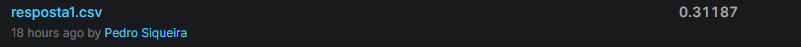

#### O modelo KNN me gerou uma pontuação de 0.63064 no Kaggle

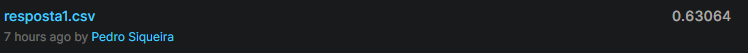

#### O modelo GradientBoost me gerou uma pontuação de 1.92905 no Kaggle

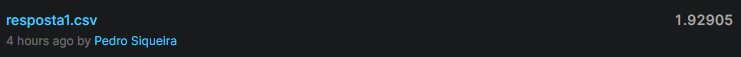

#### Como queremos a menor pontuação, o modelo escolhido foi o RandomForest

In [ ]:
resposta_final = respostaRF

exemplo['inadimplente'] = respostaRF
exemplo.to_csv('resposta1.csv', index= False)